In [1]:
import numpy as np
from scipy import misc, fft as scipy_fft
from matplotlib import pyplot, colors, cm

colors.get_named_colors_mapping().update({
    'lfd:signal': "#59a14f",
    'lfd:pupil': "#4e79a7",
    'lfd:retina': "#e15759",
})

def sampling_coordinates(n, s):
    return (np.arange(n) - (n-1)/2) * s/n

def evaluate(x, xi, amplitudes, phases):
    return np.sum(amplitudes * np.cos(2.0 * np.pi * xi * x[:, np.newaxis] + phases), axis=-1)

def spatial_display_to_eye(x_a, x_b, z_a, z_b, z_r, z_f):
    x_r = (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b
    x_p = z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b
    return x_r, x_p

def spatial_eye_to_display(x_r, x_p, z_a, z_b, z_r, z_f):
    x_a = (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p
    x_b = (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p
    return x_a, x_b

def frequency_display_to_eye(xi_a, xi_b, z_a, z_b, z_r, z_f):
    xi_r = (z_a/z_r) * xi_a + (z_b/z_r) * xi_b
    xi_p = (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b
    return xi_r, xi_p

def frequency_eye_to_display(xi_r, xi_p, z_a, z_b, z_r, z_f):
    xi_a = (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p
    xi_b = (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p
    return xi_a, xi_b

In [2]:
def plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, z_a, z_b, z_r, z_f):
    x_a = sampling_coordinates(n_a, s_a)
    x_b = sampling_coordinates(n_b, s_b)
    x_r = sampling_coordinates(n_r, s_r)

    window_x_r = (np.array([-s_r/2, -s_r/2, s_r/2, s_r/2]), np.array([100, -100, -100, 100]))
    window_x_p = (np.array([100, -100, -100, 100]), np.array([-s_p/2, -s_p/2, s_p/2, s_p/2]))

    xi_a = sampling_coordinates(n_a, n_a/s_a)
    xi_b = sampling_coordinates(n_b, n_b/s_b)
    xi_r = sampling_coordinates(n_r, n_r/s_r)

    window_xi_r = (np.array([-(n_r/s_r)/2, -(n_r/s_r)/2, (n_r/s_r)/2, (n_r/s_r)/2]), np.array([100, -100, -100, 100]))

    xi_ab = frequency_display_to_eye(np.repeat(xi_a, n_b), np.tile(xi_b, n_a), z_a, z_b, z_r, z_f)

    fig, axs = pyplot.subplots(2, 2, constrained_layout=True, figsize=(24, 24))

    axs[0, 0].set_title('Eye spatial domain', fontsize=14)
    axs[0, 0].set_xlabel(r'$x_r$', fontsize=14)
    axs[0, 0].set_ylabel(r'$x_p$', fontsize=14)
    axs[0, 0].set_aspect('equal')
    axs[0, 0].set_xticks([0])
    axs[0, 0].set_yticks([0])
    axs[0, 0].set_xlim(-20.0, 20.0)
    axs[0, 0].set_ylim(-20.0, 20.0)

    axs[0, 0].scatter(x_r, [0.0]*n_r, color='lfd:retina', zorder=3)
    axs[0, 0].scatter(*spatial_display_to_eye(np.repeat(x_a, n_b), np.tile(x_b, n_a), z_a, z_b, z_r, z_f), color='lfd:signal', marker='x', zorder=3)
    axs[0, 0].fill(*spatial_display_to_eye(np.repeat(np.repeat(x_a, n_b), 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * (s_a/n_a * 0.5 - 0.05), n_a*n_b),
                                            np.repeat(np.tile(x_b, n_a), 5) + np.tile(np.array([-1, 1, 1, -1, np.nan]) * (s_b/n_b * 0.5 - 0.05), n_a*n_b), z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:signal')
    axs[0, 0].fill(*window_x_r, alpha=0.2, color='lfd:retina')
    axs[0, 0].fill(*window_x_p, alpha=0.2, color='lfd:pupil')
    axs[0, 0].plot([-s_r/2, s_r/2], [0.0, 0.0], color='lfd:retina')
    axs[0, 0].plot(np.repeat(x_r, 3), np.tile([-s_p/2, s_p/2, np.nan], n_r), color='lfd:pupil')

    axs[0, 1].set_title('Eye frequency domain', fontsize=14)
    axs[0, 1].set_xlabel(r'$\xi_r$', fontsize=14)
    axs[0, 1].set_ylabel(r'$\xi_p$', fontsize=14)
    axs[0, 1].set_aspect('equal')
    axs[0, 1].set_xticks([0])
    axs[0, 1].set_yticks([0])
    axs[0, 1].set_xlim(-1.0, 1.0)
    axs[0, 1].set_ylim(-1.0, 1.0)

    axs[0, 1].scatter(xi_r, [0.0]*n_r, color='lfd:retina', zorder=3)
    axs[0, 1].scatter(*xi_ab, color='lfd:signal', marker='x', zorder=3)
    axs[0, 1].fill(*window_xi_r, alpha=0.2, color='lfd:retina')
    axs[0, 1].axline((0.0, 0.0), (1.0, 0.0), color='lfd:retina')
    axs[0, 1].plot(np.repeat(xi_ab[0], 3), np.repeat(xi_ab[1], 3) * np.tile([1, 0, np.nan], n_a*n_b), color='lfd:pupil')

    axs[1, 0].set_title('Display spatial domain', fontsize=14)
    axs[1, 0].set_xlabel(r'$x_a$', fontsize=14)
    axs[1, 0].set_ylabel(r'$x_b$', fontsize=14)
    axs[1, 0].set_aspect('equal')
    axs[1, 0].set_xticks([0])
    axs[1, 0].set_yticks([0])
    axs[1, 0].set_xlim(-10.0, 10.0)
    axs[1, 0].set_ylim(-10.0, 10.0)

    axs[1, 0].scatter(*spatial_eye_to_display(x_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', zorder=3)
    axs[1, 0].scatter(np.repeat(x_a, n_b), np.tile(x_b, n_a), color='lfd:signal', marker='x', zorder=3)
    axs[1, 0].fill(np.repeat(np.repeat(x_a, n_b), 5) + np.tile(np.array([-1, -1, 1, 1, np.nan]) * (s_a/n_a * 0.5 - 0.05), n_a*n_b),
                    np.repeat(np.tile(x_b, n_a), 5) + np.tile(np.array([-1, 1, 1, -1, np.nan]) * (s_b/n_b * 0.5 - 0.05), n_a*n_b), alpha=0.2, color='lfd:signal')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_r, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:retina')
    axs[1, 0].fill(*spatial_eye_to_display(*window_x_p, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:pupil')
    axs[1, 0].plot(*spatial_eye_to_display(np.array([-s_r/2, s_r/2]), 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
    axs[1, 0].plot(*spatial_eye_to_display(np.repeat(x_r, 3), np.tile([-s_p/2, s_p/2, np.nan], n_r), z_a, z_b, z_r, z_f), color='lfd:pupil')

    axs[1, 1].set_title('Display frequency domain', fontsize=14)
    axs[1, 1].set_xlabel(r'$\xi_a$', fontsize=14)
    axs[1, 1].set_ylabel(r'$\xi_b$', fontsize=14)
    axs[1, 1].set_aspect('equal')
    axs[1, 1].set_xticks([0])
    axs[1, 1].set_yticks([0])
    axs[1, 1].set_xlim(-1.0, 1.0)
    axs[1, 1].set_ylim(-1.0, 1.0)

    axs[1, 1].scatter(*frequency_eye_to_display(xi_r, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina', zorder=3)
    axs[1, 1].scatter(np.repeat(xi_a, n_b), np.tile(xi_b, n_a), color='lfd:signal', marker='x', zorder=3)
    axs[1, 1].fill(*frequency_eye_to_display(*window_xi_r, z_a, z_b, z_r, z_f), alpha=0.2, color='lfd:retina')
    axs[1, 1].axline((0.0, 0.0), frequency_eye_to_display(1.0, 0.0, z_a, z_b, z_r, z_f), color='lfd:retina')
    axs[1, 1].plot(*frequency_eye_to_display(np.repeat(xi_ab[0], 3), np.repeat(xi_ab[1], 3) * np.tile([1, 0, np.nan], n_a*n_b), z_a, z_b, z_r, z_f), color='lfd:pupil')

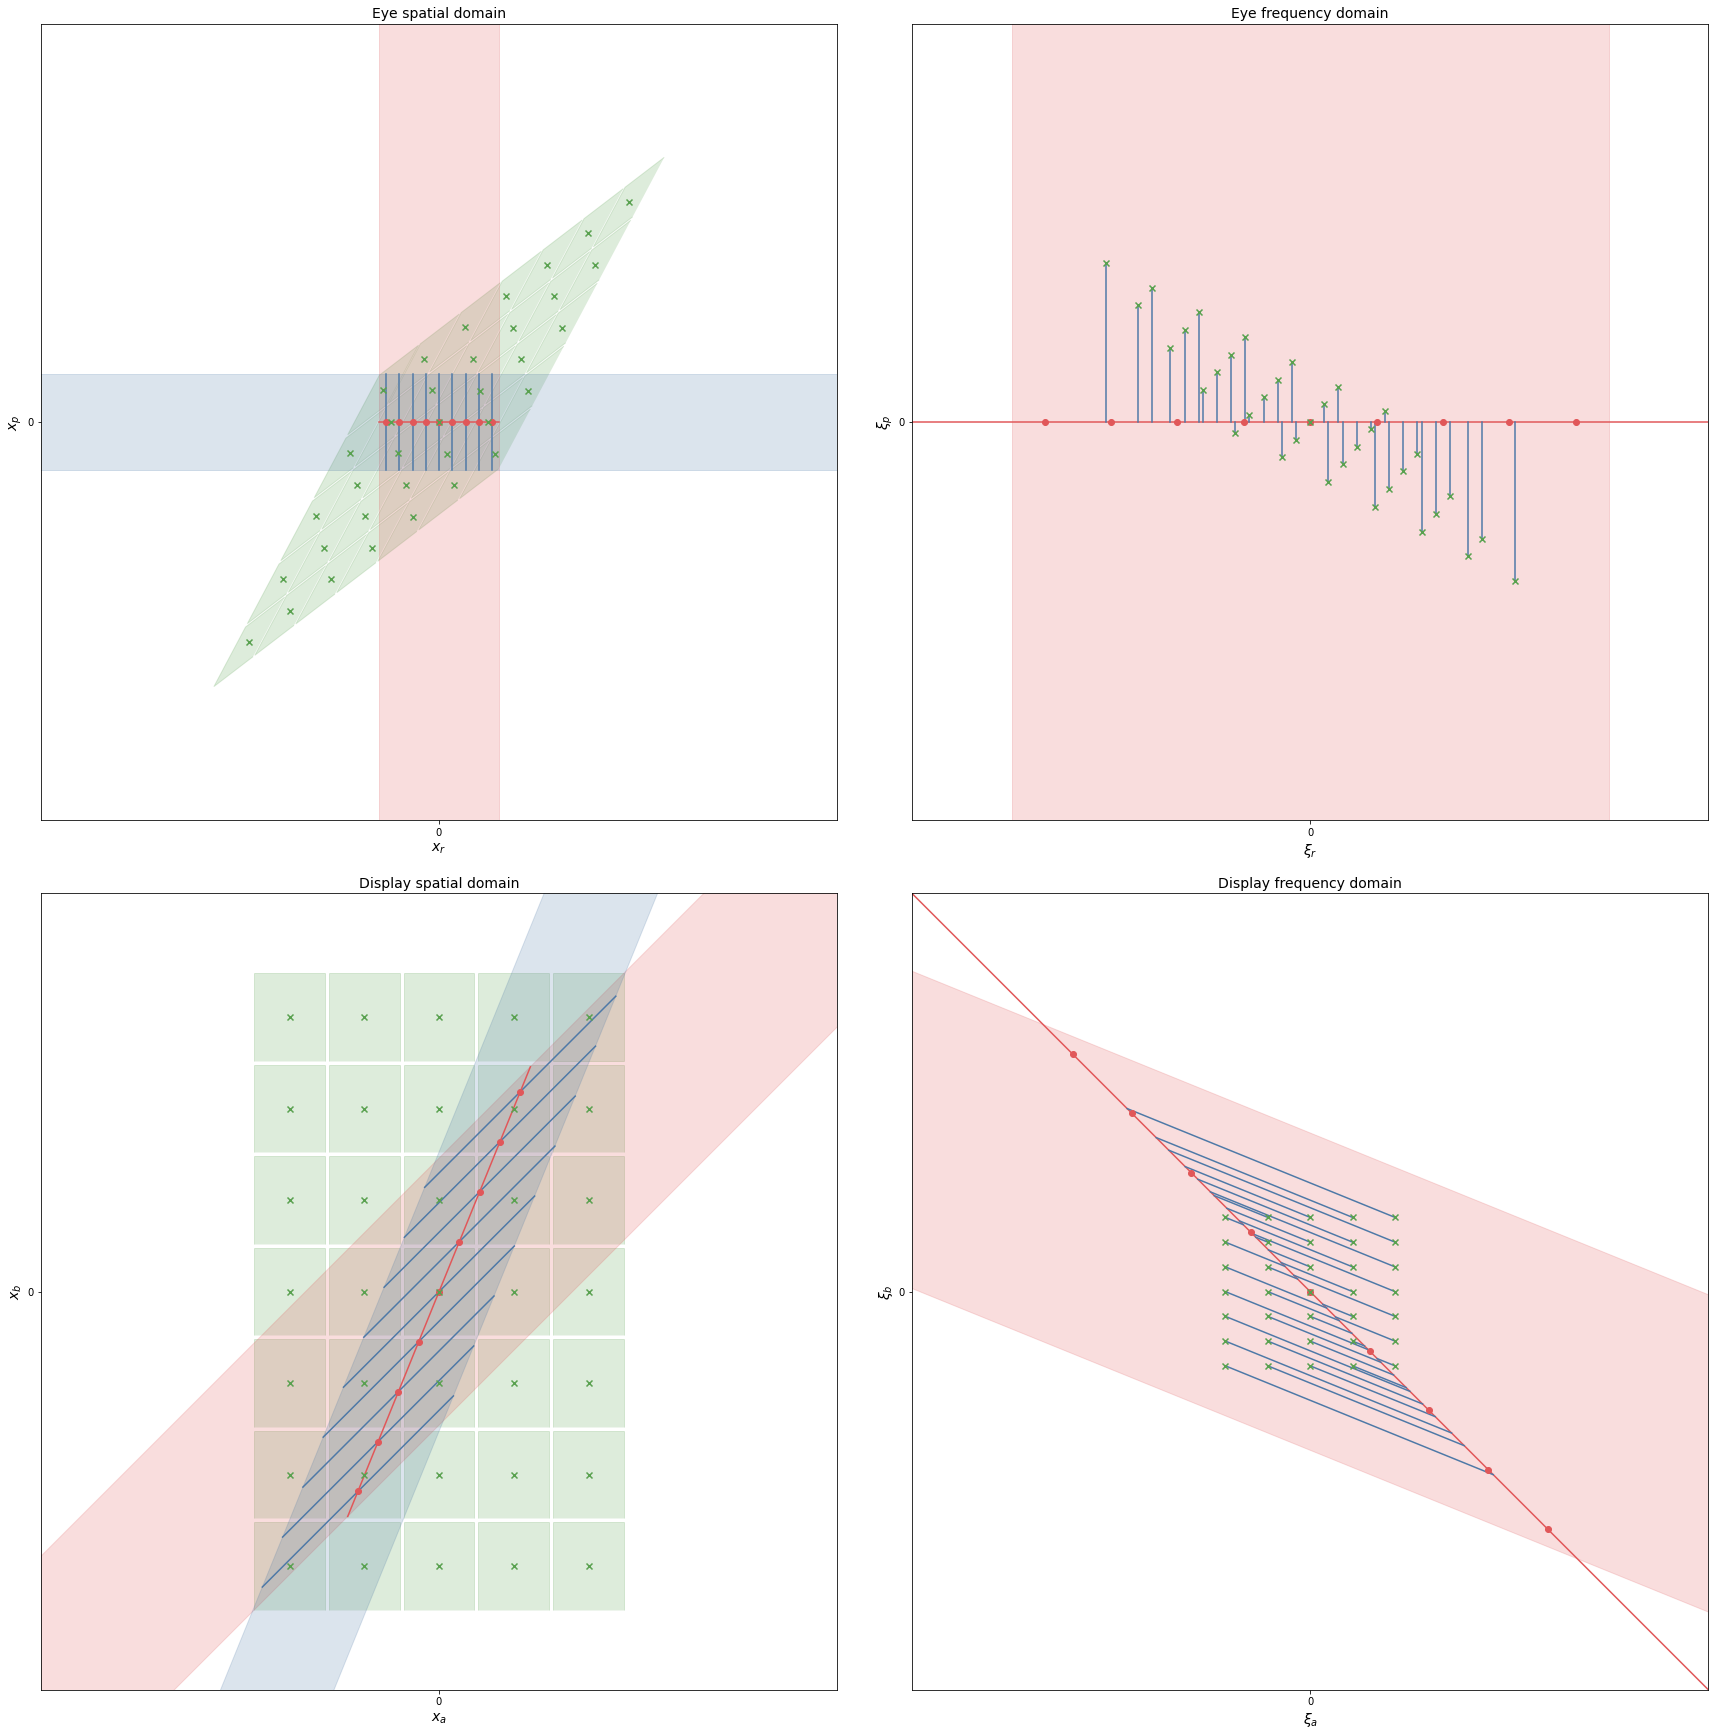

In [3]:
z_a = 13.0
z_b = 32.0
z_r = -17.0
z_f = np.inf

n_a = 5
n_b = 7
n_r = 9

s_p = 4.8
s_r = 6.0

s_a = s_r * abs(z_a/z_r) + s_p
s_b = s_r * abs(z_b/z_r) + s_p

plot_domains(n_a, n_b, n_r, s_a, s_b, s_r, s_p, z_a, z_b, z_r, z_f)

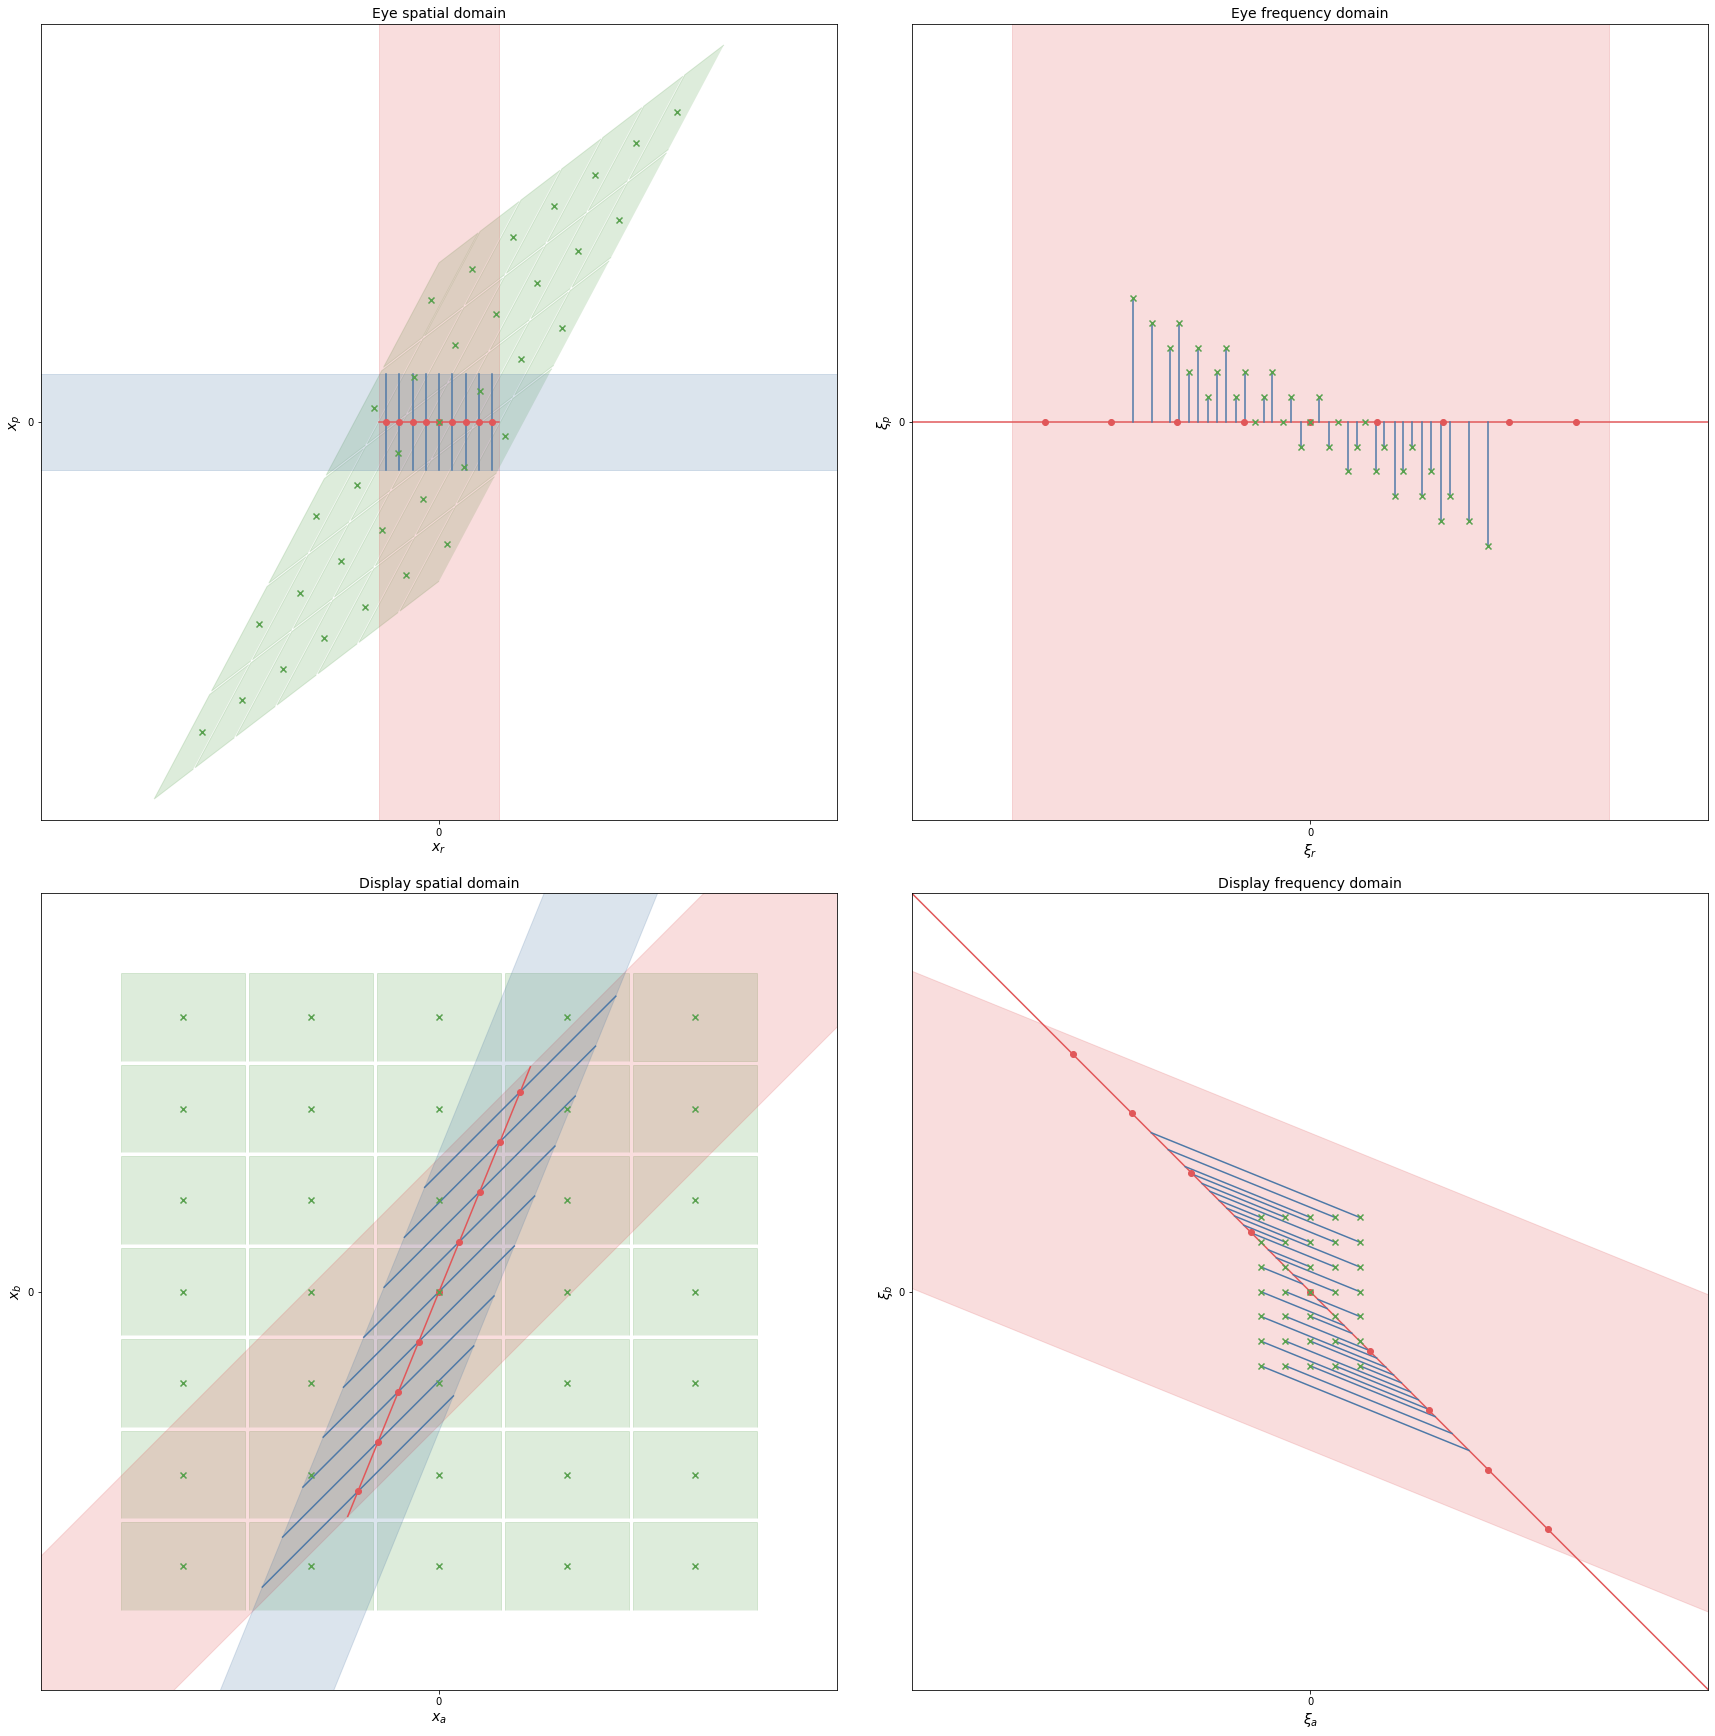

In [4]:
plot_domains(n_a, n_b, n_r, s_b, s_b, s_r, s_p, z_a, z_b, z_r, z_f)

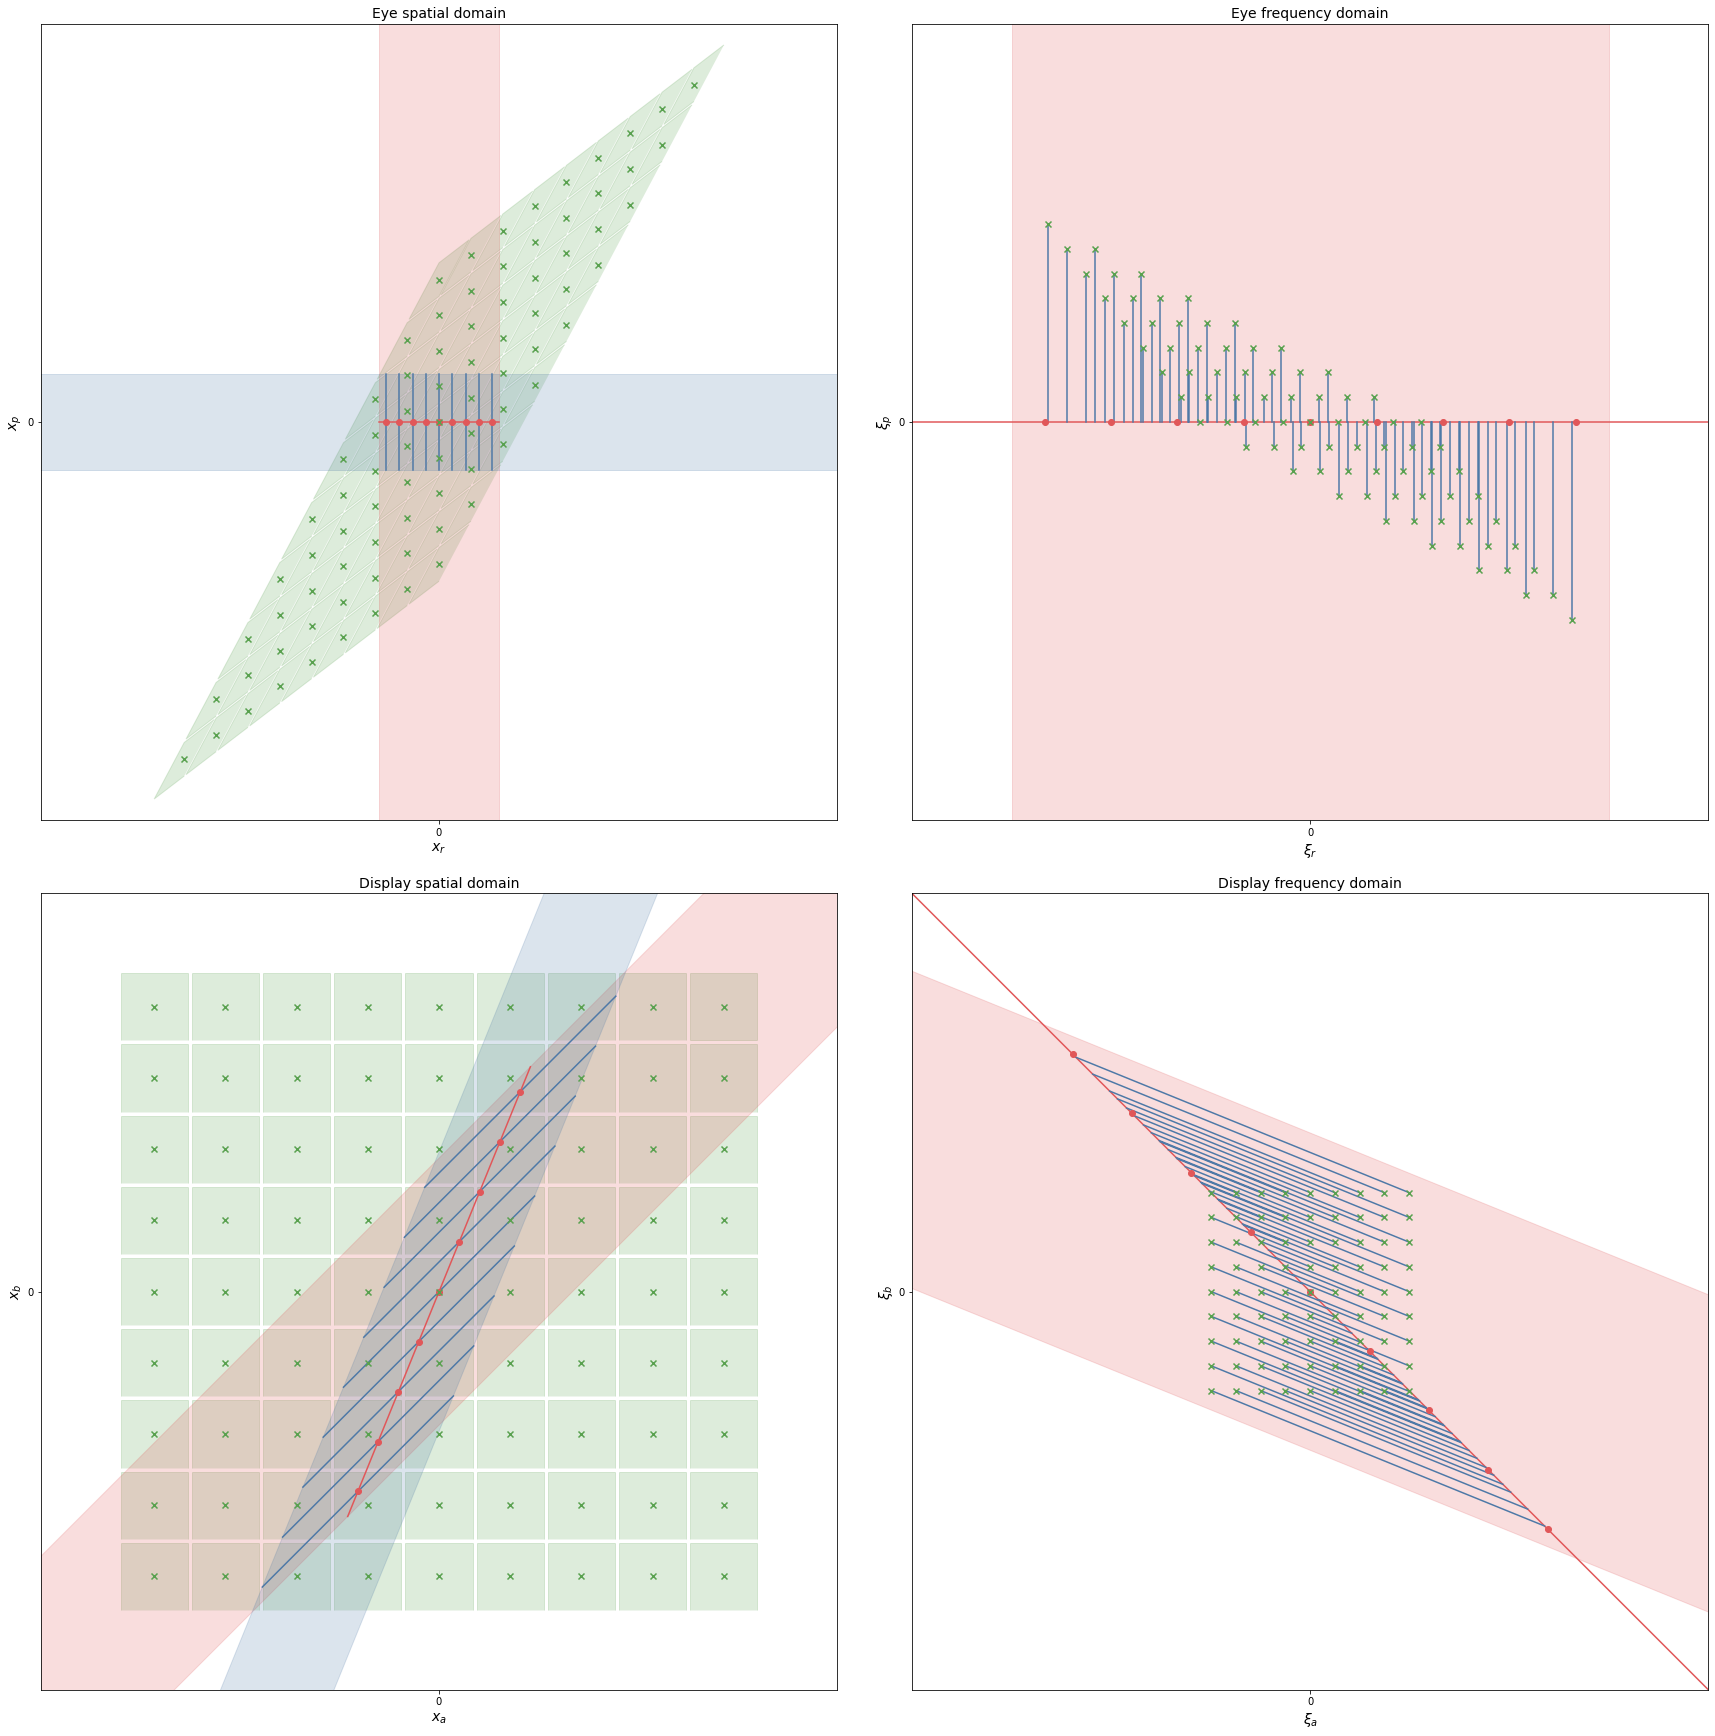

In [5]:
plot_domains(n_r, n_r, n_r, s_b, s_b, s_r, s_p, z_a, z_b, z_r, z_f)

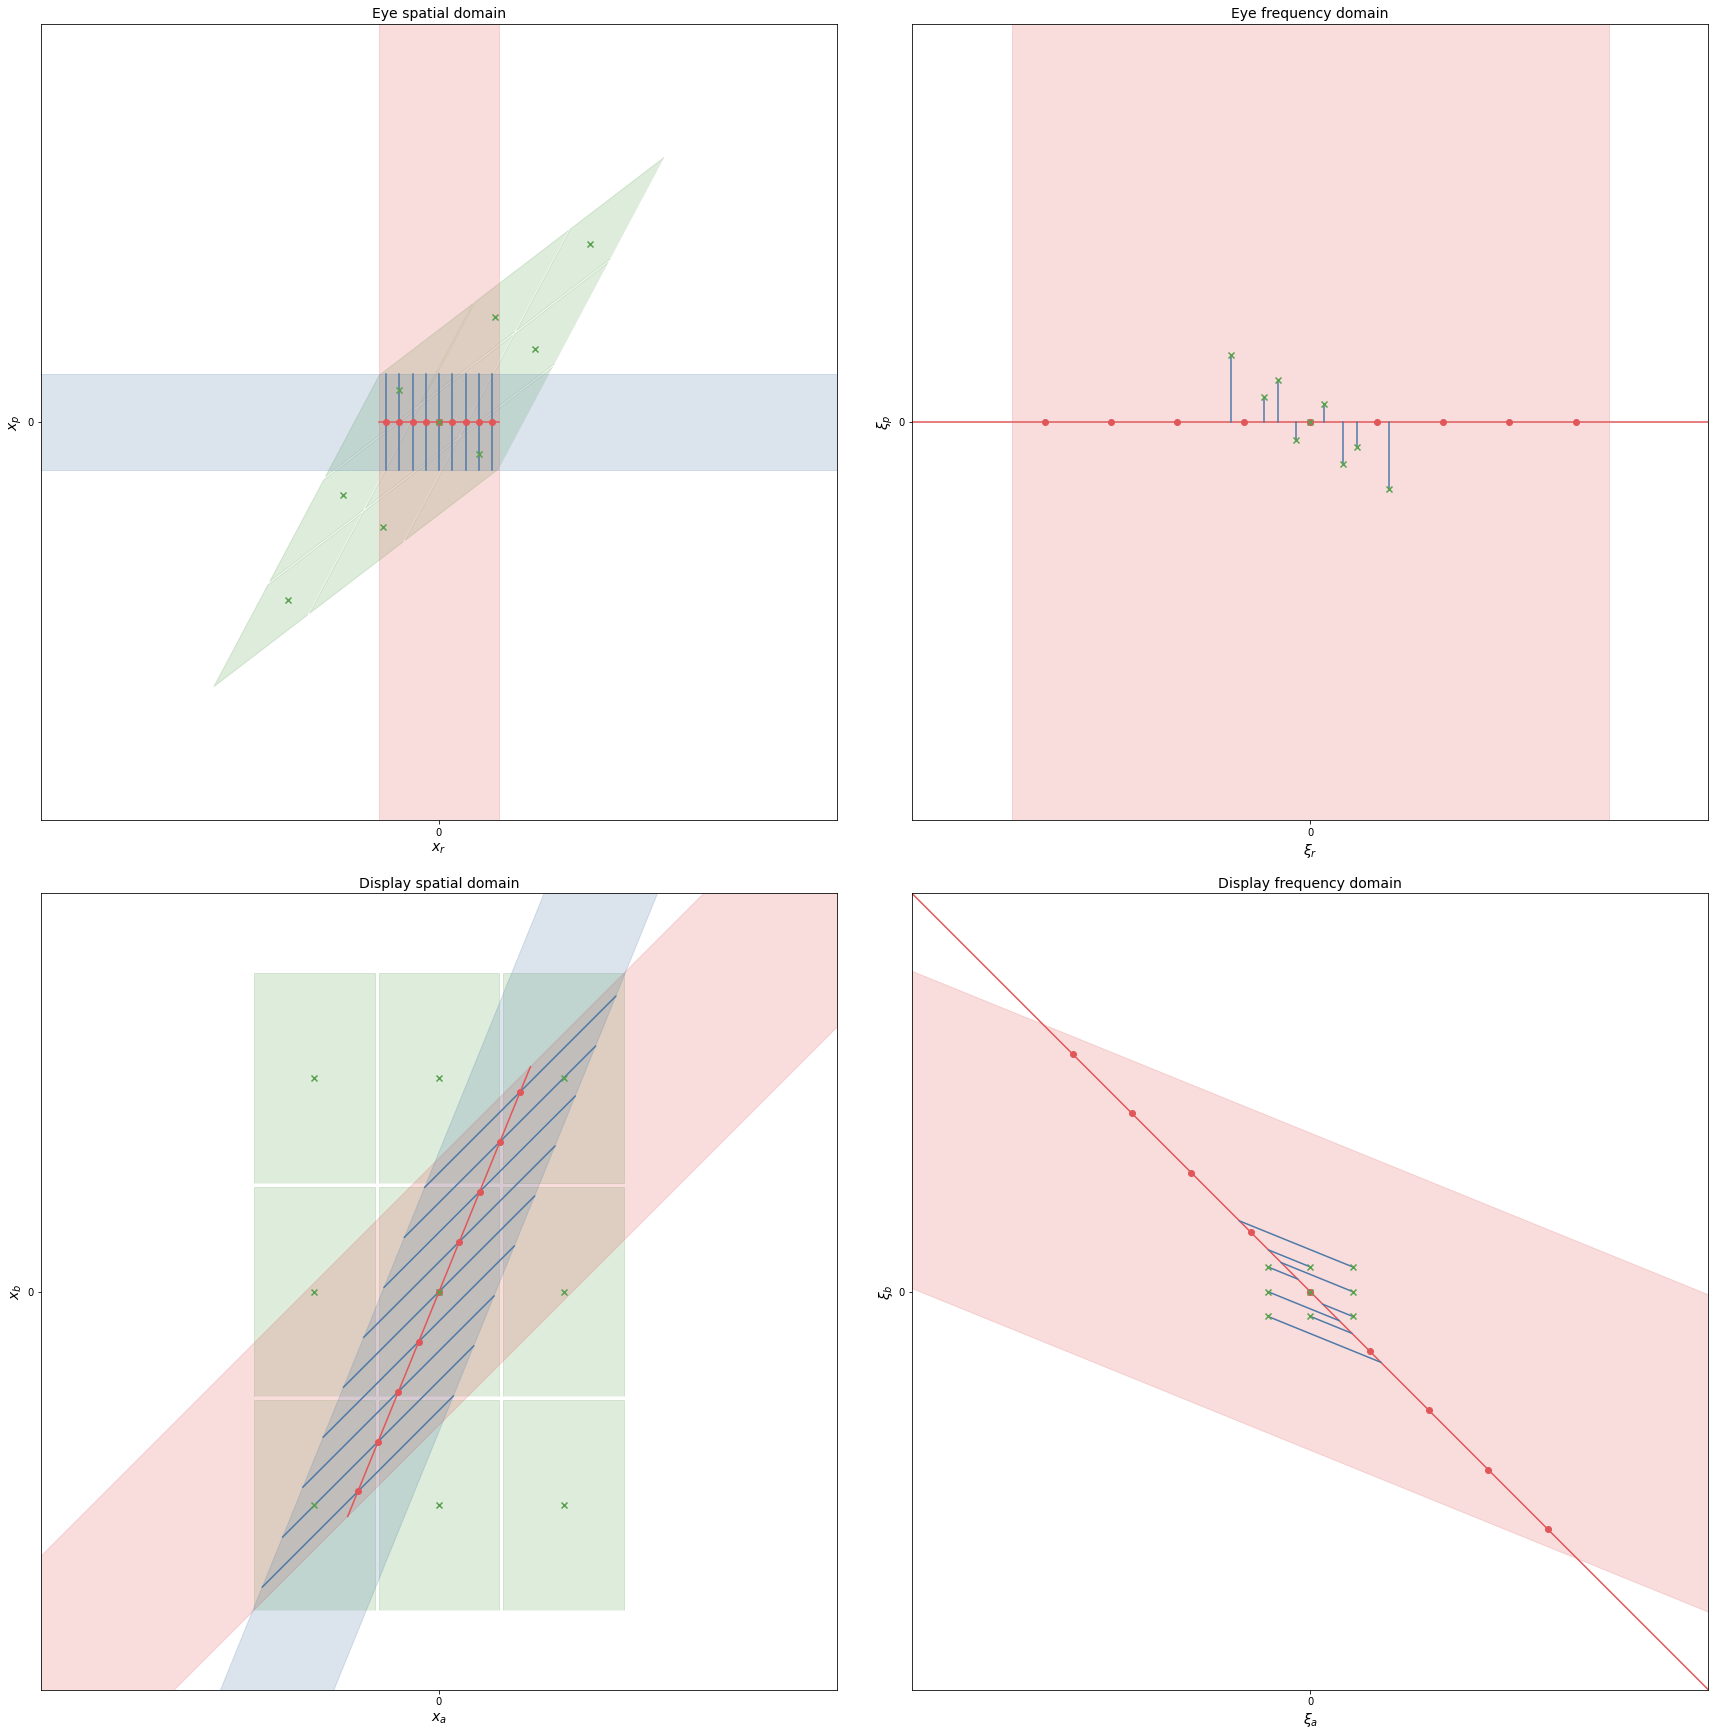

In [6]:
plot_domains(3, 3, n_r, s_a, s_b, s_r, s_p, z_a, z_b, z_r, z_f)